In [8]:
from Strats.RandomStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *
from Data.BinanceSymbolManager import *
from Data.BinancePriceFetcher import *
import warnings

warnings.filterwarnings("ignore")

In [87]:
# test_pairs = coint_pairs[:4]
test_cons = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
print(test_cons)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_cons:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
portfolio_prices = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-07-01",
        end_date="2025-05-31"
    )

portfolio_prices

['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
'BTCUSDT' added successfully.
'ETHUSDT' added successfully.
'BNBUSDT' added successfully.


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT
0,2024-07-01 00:00:00,582.00,62722.08,3437.02
1,2024-07-01 00:05:00,580.60,62648.49,3433.81
2,2024-07-01 00:10:00,580.40,62624.00,3435.74
3,2024-07-01 00:15:00,581.00,62682.02,3438.27
4,2024-07-01 00:20:00,581.30,62674.01,3438.29
...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34


In [88]:
test_start_date, test_end_date = "2024-07-01", "2025-05-31"
stoploss = 10e6
drawdown_duration = 10e6
rolling=2000
weight_method=equal_weighting
short = False

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_bnb = portfolio_prices[['timestamp', 'BNBUSDT']]
df_eth = portfolio_prices[['timestamp', 'ETHUSDT']]
df_btc = portfolio_prices[['timestamp', 'BTCUSDT']]


from IPython.display import display

print("📈 BNBUSDT Preview:")
display(df_bnb.head())

print("📈 ETHUSDT Preview:")
display(df_eth.head())

print("📈 BTCUSDT Preview:")
display(df_btc.head())



📈 BNBUSDT Preview:


,timestamp,BNBUSDT
0,2024-07-01 00:00:00,582.0
1,2024-07-01 00:05:00,580.6
2,2024-07-01 00:10:00,580.4
3,2024-07-01 00:15:00,581.0
4,2024-07-01 00:20:00,581.3


📈 ETHUSDT Preview:


,timestamp,ETHUSDT
0,2024-07-01 00:00:00,3437.02
1,2024-07-01 00:05:00,3433.81
2,2024-07-01 00:10:00,3435.74
3,2024-07-01 00:15:00,3438.27
4,2024-07-01 00:20:00,3438.29


📈 BTCUSDT Preview:


,timestamp,BTCUSDT
0,2024-07-01 00:00:00,62722.08
1,2024-07-01 00:05:00,62648.49
2,2024-07-01 00:10:00,62624.00
3,2024-07-01 00:15:00,62682.02
4,2024-07-01 00:20:00,62674.01


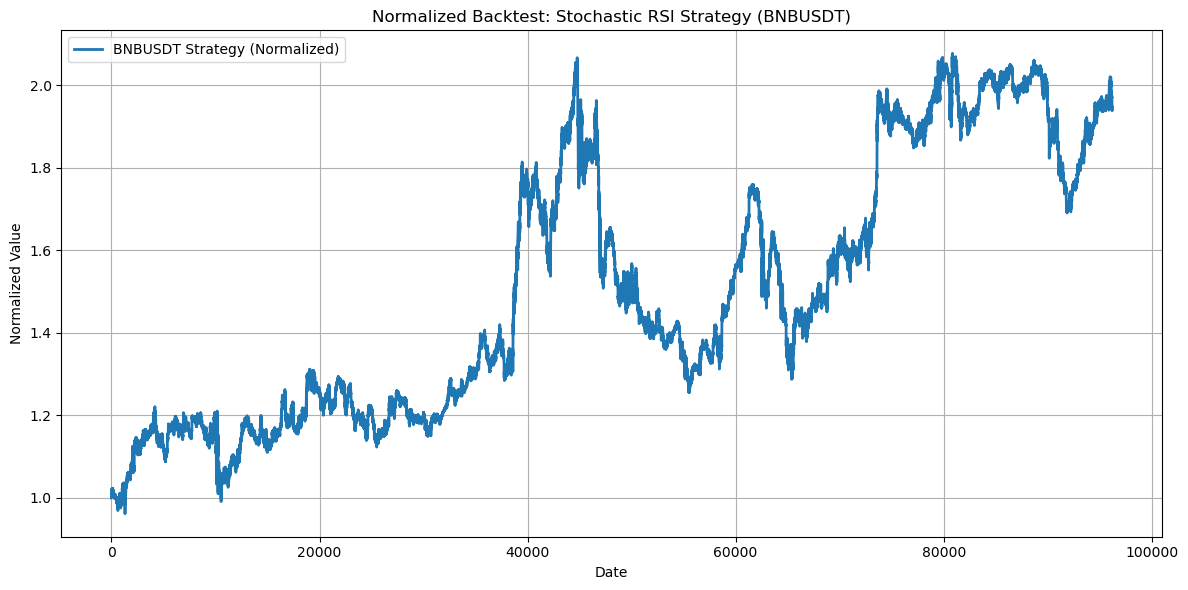


📊 Strategy Performance Summary (BNBUSDT):

| Metric            |   Metric Value (BNBUSDT) |
|:------------------|-------------------------:|
| Sharpe Ratio      |                   1.5335 |
| Max Drawdown (%)  |                 -39.27   |
| Signal Count (1)  |               19886      |
| Signal Count (-1) |               30341      |
| Signal Count (0)  |               45966      |


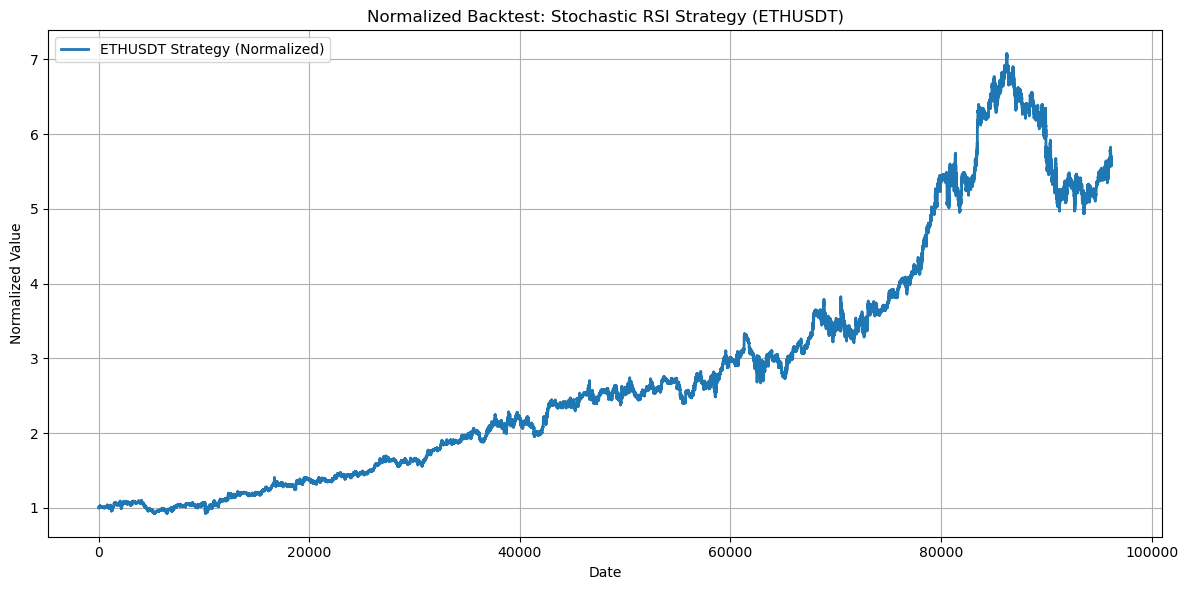


📊 Strategy Performance Summary (ETHUSDT):

| Metric            |   Metric Value (ETHUSDT) |
|:------------------|-------------------------:|
| Sharpe Ratio      |                   2.9362 |
| Max Drawdown (%)  |                 -30.31   |
| Signal Count (1)  |               19643      |
| Signal Count (-1) |               29244      |
| Signal Count (0)  |               47306      |


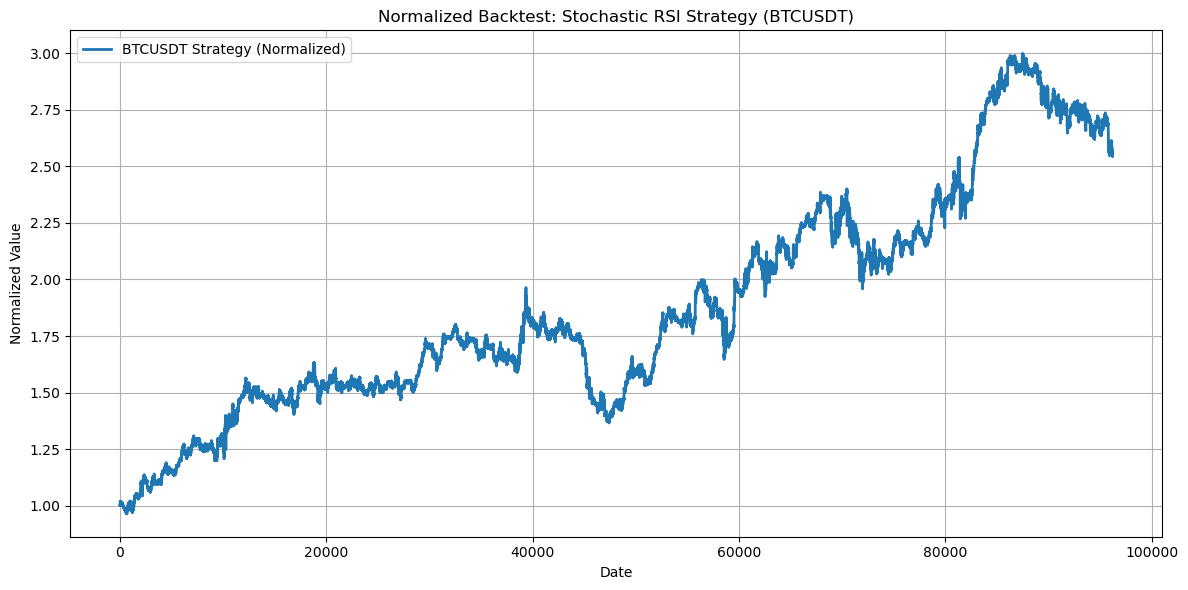


📊 Strategy Performance Summary (BTCUSDT):

| Metric            |   Metric Value (BTCUSDT) |
|:------------------|-------------------------:|
| Sharpe Ratio      |                   2.1972 |
| Max Drawdown (%)  |                 -30.47   |
| Signal Count (1)  |               20267      |
| Signal Count (-1) |               29292      |
| Signal Count (0)  |               46634      |


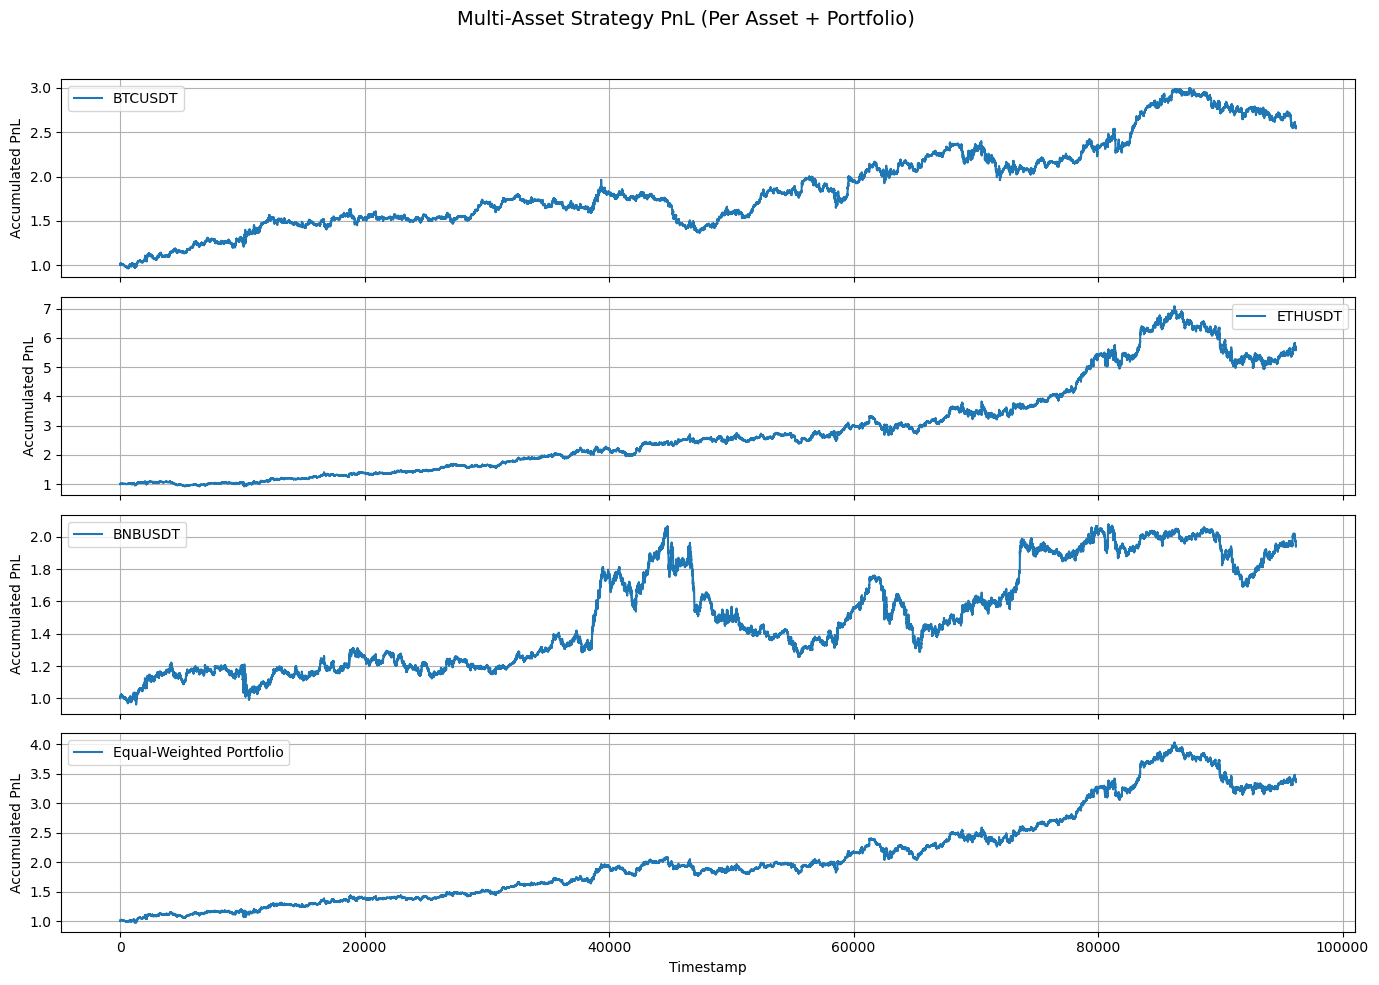

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. RSI using Wilder's EMA ===
def compute_rsi_wilder(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === 2. Stochastic RSI with EMA smoothing ===
def compute_stoch_rsi_ema(price_series, rsi_period=14, stoch_period=14, k_smooth=3, d_smooth=3):
    rsi = compute_rsi_wilder(price_series, rsi_period)
    min_rsi = rsi.rolling(window=stoch_period).min()
    max_rsi = rsi.rolling(window=stoch_period).max()
    stoch_rsi = (rsi - min_rsi) / (max_rsi - min_rsi)
    k = stoch_rsi.ewm(span=k_smooth, adjust=False).mean() * 100
    d = k.ewm(span=d_smooth, adjust=False).mean()
    return rsi, stoch_rsi, k, d

# === 3. Apply strategy and backtest ===
def apply_strategy_and_backtest(df, ticker, label='Full Dataset', bars_per_day=288):
    df = df.copy()
    df['RSI'], df['StochRSI'], df['%K'], df['%D'] = compute_stoch_rsi_ema(df[ticker])

    df['Signal'] = 0
    bullish_crossover = (df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] > df['%D'])
    bearish_crossover = (df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] < df['%D'])
    oversold_k = df['%K'] < 10
    overbought_k = df['%K'] > 80
    rsi_buy_condition = df['RSI'] < 10
    rsi_sell_condition = df['RSI'] >= 90

    buy_signal = bullish_crossover | oversold_k | rsi_buy_condition
    sell_signal = bearish_crossover | overbought_k | rsi_sell_condition
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df.loc[buy_signal & sell_signal, 'Signal'] = 0

    df_bt = df[[ticker, 'Signal']].dropna().copy()
    df_bt['Position'] = df_bt['Signal'].replace(to_replace=0, method='ffill')
    df_bt['Returns'] = df_bt[ticker].pct_change()
    df_bt['Strategy_Returns'] = df_bt['Returns'] * df_bt['Position'].shift(1)
    df_bt['Normalized_Strategy'] = (1 + df_bt['Strategy_Returns'].fillna(0)).cumprod()

    # Plot strategy PnL
    plt.figure(figsize=(12, 6))
    plt.plot(df_bt.index, df_bt['Normalized_Strategy'], label=f'{label} Strategy (Normalized)', linewidth=2)
    plt.title(f"Normalized Backtest: Stochastic RSI Strategy ({label})")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary metrics
    df_bt['Cumulative_Strategy'] = (1 + df_bt['Strategy_Returns'].fillna(0)).cumprod()
    sharpe_ratio = np.sqrt(bars_per_day * 365) * df_bt['Strategy_Returns'].mean() / df_bt['Strategy_Returns'].std()
    df_bt['Peak'] = df_bt['Cumulative_Strategy'].cummax()
    df_bt['Drawdown'] = (df_bt['Cumulative_Strategy'] - df_bt['Peak']) / df_bt['Peak']
    max_drawdown = df_bt['Drawdown'].min()
    signal_counts = df_bt['Signal'].value_counts().to_dict()

    performance_summary = {
        'Sharpe Ratio': round(sharpe_ratio, 4),
        'Max Drawdown (%)': round(max_drawdown * 100, 2),
        'Signal Count (1)': signal_counts.get(1, 0),
        'Signal Count (-1)': signal_counts.get(-1, 0),
        'Signal Count (0)': signal_counts.get(0, 0)
    }
    summary_df = pd.DataFrame.from_dict(performance_summary, orient='index', columns=[f'Metric Value ({label})'])
    summary_df.index.name = 'Metric'
    print(f"\n📊 Strategy Performance Summary ({label}):\n")
    print(summary_df.to_markdown())

    return df, df_bt

# === 4. Run strategy across all 3 datasets ===
df_bnb, df_bnb_bt = apply_strategy_and_backtest(df_bnb, ticker="BNBUSDT", label="BNBUSDT")
df_eth, df_eth_bt = apply_strategy_and_backtest(df_eth, ticker="ETHUSDT", label="ETHUSDT")
df_btc, df_btc_bt = apply_strategy_and_backtest(df_btc, ticker="BTCUSDT", label="BTCUSDT")

# === 5. Portfolio PnL Plot ===
def compute_pnl(df_bt, label):
    pnl = (1 + df_bt['Strategy_Returns'].fillna(0)).cumprod()
    pnl.name = label
    return pnl

pnl_bnb = compute_pnl(df_bnb_bt, 'BNBUSDT_PnL_Total')
pnl_eth = compute_pnl(df_eth_bt, 'ETHUSDT_PnL_Total')
pnl_btc = compute_pnl(df_btc_bt, 'BTCUSDT_PnL_Total')

pnl_df = pd.concat([pnl_bnb, pnl_eth, pnl_btc], axis=1).dropna()
pnl_df['Portfolio'] = pnl_df.mean(axis=1)

fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

pnl_df['BTCUSDT_PnL_Total'].plot(ax=axs[0], label='BTCUSDT')
axs[0].set_ylabel("Accumulated PnL")
axs[0].legend()
axs[0].grid(True)

pnl_df['ETHUSDT_PnL_Total'].plot(ax=axs[1], label='ETHUSDT')
axs[1].set_ylabel("Accumulated PnL")
axs[1].legend()
axs[1].grid(True)

pnl_df['BNBUSDT_PnL_Total'].plot(ax=axs[2], label='BNBUSDT')
axs[2].set_ylabel("Accumulated PnL")
axs[2].legend()
axs[2].grid(True)

pnl_df['Portfolio'].plot(ax=axs[3], label='Equal-Weighted Portfolio')
axs[3].set_ylabel("Accumulated PnL")
axs[3].set_xlabel("Timestamp")
axs[3].legend()
axs[3].grid(True)

plt.suptitle("Multi-Asset Strategy PnL (Per Asset + Portfolio)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [91]:
random_strat = RandomStrat(data=portfolio_prices)
random_df = random_strat.random_strategy(lookback=12*24*3, hold_period=12*24*3)

In [92]:
random_backtest = Backtest(random_df.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
random_pnl_df = random_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
random_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-07-01 00:00:00,0.000000,0.000000
1,2024-07-01 00:05:00,0.000000,0.000000
2,2024-07-01 00:10:00,0.000000,0.000000
3,2024-07-01 00:15:00,0.000000,0.000000
4,2024-07-01 00:20:00,0.000000,0.000000
...,...,...,...
96188,2025-05-30 23:40:00,690.313333,6177.773333
96189,2025-05-30 23:45:00,598.813333,6086.273333
96190,2025-05-30 23:50:00,617.556667,6105.016667
96191,2025-05-30 23:55:00,625.043333,6112.503333


In [93]:
random_returns = random_backtest.get_returns(random_pnl_df, notional=10e6)

In [113]:
rsi_returns = pnl_df['Portfolio'].diff().values[-len(random_returns):]

In [130]:
rsi_returns

array([ 0.00015128,  0.00038664,  0.00035483, ..., -0.00092383,
       -0.00153548,  0.00474292])

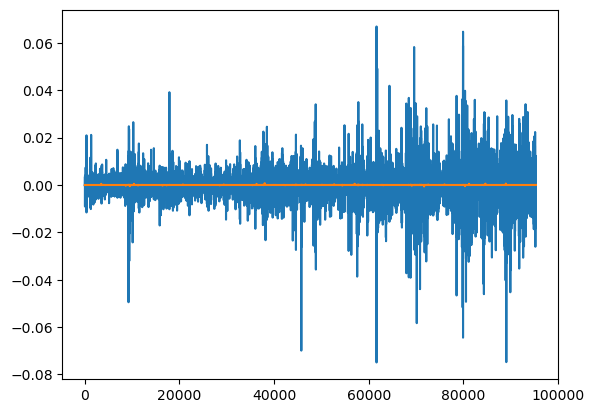

In [116]:
plt.plot(rsi_returns)
plt.plot(random_returns)

In [135]:
wrc = WhiteRealityCheck(strategies=rsi_returns, benchmark=random_returns)
wrc.run()

White Reality Check Results:
p-value: lower         0.008
consistent    0.008
upper         0.008
dtype: float64
